We'll be using [Ray](https://ray.io) to develop our application using distributed workloads.

# 🛠️ Setup

In [1]:
import os
import ray

In [2]:
import sys; sys.path.append("..")
import warnings; warnings.filterwarnings("ignore")
from dotenv import load_dotenv; load_dotenv()
%load_ext autoreload
%autoreload 2

In [3]:
# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

2024-07-04 16:16:09,002	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


Python version:,3.10.11
Ray version:,2.7.1
Dashboard:,http://127.0.0.1:8266


In [4]:
ray.cluster_resources()

{'memory': 6103726490.0,
 'CPU': 10.0,
 'node:__internal_head__': 1.0,
 'object_store_memory': 2147483648.0,
 'node:127.0.0.1': 1.0}

In [5]:
# Workers (1 g4dn.xlarge)
num_workers = 6
resources_per_worker={"CPU": 1, "GPU": 0}

In [6]:
# Storage
EFS_DIR = f"/efs/shared_storage/madewithml/sinapordanesh"
print (EFS_DIR)

/efs/shared_storage/madewithml/sinapordanesh


# Data

| Assumption | Reality | Reason |
| --- | --- | --- |
| All of our incoming data is only machine learning related (no spam). | We would need a filter to remove spam content that's not ML related. | To simplify our ML task, we will assume all the data is ML content. |

## Data ingestion

In [7]:
import pandas as pd

In [8]:
# Data ingestion
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


## Spliting the data

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# Value counts
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [11]:
# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

In [12]:
# Train value counts
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

![Validation value counts](./images/Validation%20(adjusted)%20value%20counts.png)

In [13]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size) / test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

## 🔍 Exploratory Data Analysis (EDA)

Exploratory data analysis to understand the signals and nuances of our dataset. It's a cyclical process that can be done at various points of our development process (before/after labeling, preprocessing, etc.) depending on how well the problem is defined.

- not just to visualize a prescribed set of plots (correlation matrix, etc.).
- goal is to convince yourself that the data you have is sufficient for the task.
- use EDA to answer important questions and to make it easier to extract insight
- not a one time process; as your data grows, you want to revisit EDA to catch distribution shifts, anomalies, etc.

In [14]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

In [15]:
# Most common tags
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

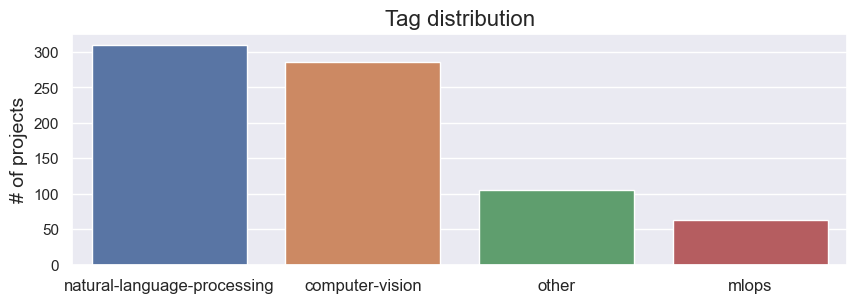

In [16]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=12)
plt.title("Tag distribution", fontsize=16)
plt.ylabel("# of projects", fontsize=14)
plt.show()

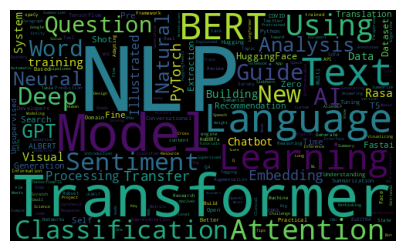

In [17]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)


Looks like the `title` text feature has some good signal for the respective classes and matches our intuition. We can repeat this for the `description` text feature as well. This information will become useful when we decide how to use our features for modeling.

## ✨ Data Preprocessing

Preprocessing the data via feature engineering, filtering and cleaning. Certain preprocessing steps are global (don't depend on our dataset, ex. lower casing text, removing stop words, etc.) and others are local (constructs are learned only from the training split, ex. vocabulary, standardization, etc.). For the local, dataset-dependent preprocessing steps, we want to ensure that we split the data first before preprocessing to avoid data leaks.

In [18]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

### Feature engineering

We can combine existing input features to create new meaningful signal (helping the model learn). 

In [19]:
# Feature engineering
df["text"] = df.title + " " + df.description

### Clean text

In [20]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /Users/sina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links
    
    return text

In [22]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


### Clean DataFrame

In [23]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


### Label encoding

We need to encode our data into numerical values so that our models can process them. We'll start by encoding our text labels into unique indices.

In [24]:
# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [25]:
# Encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [26]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [27]:
index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

### Tokenizer

Next we'll encode our text as well. Instead of using a random dictionary, we'll use a [tokenizer](https://huggingface.co/allenai/scibert_scivocab_uncased/blob/main/vocab.txt) that was used for a pretrained LLM ([scibert](https://huggingface.co/allenai/scibert_scivocab_uncased)) to tokenize our text. We'll be fine-tuning this exact model later when we train our model.

In [28]:
import numpy as np
from transformers import BertTokenizer

In [29]:
# Bert tokenizer
# A sample on how this library works on a sample data
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [30]:
# The main function that we want to use for tokenization process
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [31]:
# Tokenization 
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([2])}

We'll combine all of our preprocessing steps into function:

In [32]:
# This function is the combination of all steps we've taken on data processing, uder a same roof.
# This function will be used for the later data processing progress on our training data, before training. 
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [33]:
# Apply 
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 1, 1, 1, 2, 1, 2, 0, 3, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 3, 3,
        3, 0, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 1, 3, 1, 0,
        1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 0, 1, 1,
        1, 1, 3, 3, 0, 2, 3, 2, 2, 1, 1, 3, 2, 3, 1, 1, 1, 1, 2, 0, 0, 2,
        1, 1, 2, 2, 1, 1, 0, 3, 1

# Distributed preprocessing

The main issue with our approach above is that we're limited by our single machine in terms how much data our dataframe can hold and that we can preprocess. With the increasing trend in ML for larger unstructured datasets and larger models (LLMs), we can quickly outgrow our single machine constraints and will need to go distributed.

In [34]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = True  # deterministic

In [35]:
# Data ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

2024-07-04 16:16:16,595	INFO read_api.py:406 -- To satisfy the requested parallelism of 20, each read task output is split into 20 smaller blocks.
2024-07-04 16:16:16,607	INFO dataset.py:2380 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2024-07-04 16:16:16,609	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-07-04 16:16:16,610	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:16:16,610	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 549,
  'created_on': datetime.datetime(2020, 4, 16, 3, 48, 35),
  'title': '15 Best Tools for Tracking Machine Learning Experiments',
  'description': 'A feature comparison of all the open-source and commercial options for experiment tracking.',
  'tag': 'mlops'}]

In [36]:
import sys
sys.path.append("..")
from madewithml.data import stratify_split # A modified version of train_test_split function of Ray

In [37]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2024-07-04 16:16:18,131	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-07-04 16:16:18,132	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:16:18,132	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
# Mapping 
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

2024-07-04 16:16:18,536	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2024-07-04 16:16:18,536	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:16:18,537	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

2024-07-04 16:16:20,462	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2024-07-04 16:16:20,466	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:16:20,466	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

In [39]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(preprocess, fn_kwargs={"class_to_index": class_to_index}, batch_format="pandas")
sample_ds.show(1)

2024-07-04 16:16:21,565	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2024-07-04 16:16:21,566	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:16:21,567	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

(MapBatches(preprocess) pid=19792) /Users/sina/Documents/GitHub_Local/mlops/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess) pid=19792)   warnings.warn(
(MapBatches(preprocess) pid=19792) /Users/sina/Documents/GitHub_Local/mlops/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess) pid=19792)   warnings.warn(
(MapBatches(preprocess) pid=19792) /Users/sina/Documents/GitHub_Local/mlops/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in 

{'ids': array([  102,  2389, 29477,  3254,  1572,  6773,  4459,  3041,   791,
        2389, 29477,  3350,  2389, 21591,  3254,  7398,  1572,  6773,
        9153,  1098,  5751,  1332,   532,  1186,   103,     0,     0,
           0,     0,     0,     0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0]), 'targets': 0}


# Training

When developing models, it's always a best practice to start with the simplest models and slowly motivate more complex models. For example our baseline model progression would be: 

1. random model (predict labels randomly)
2. rule-based model (pattern match labels in input text)
3. logistic regression (td-idf vectors from text)
4. CNN (apply character filters over text)
5. Fine-tune LLM (this notebook)

We'll first set up some functions that will help us achieve complete reproducibility.

In [40]:
import os
import random
import torch
from ray.data.preprocessor import Preprocessor

In [41]:
# set the seeds for reproducibility across our libraries 
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [42]:
def load_data(num_samples=None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [43]:
class CustomPreprocessor():
    """Custom preprocessor class."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        
    def fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        return self
    
    def transform(self, ds):
        return ds.map_batches(
            preprocess, 
            fn_kwargs={"class_to_index": self.class_to_index}, 
            batch_format="pandas")

## 🤖 Model

In [44]:
import torch.nn as nn
from transformers import BertModel

In [45]:
# Pretrained LLM 
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


![Bert Model](./images/bert.png)

In [46]:
# Sample fine tuning the Bert model using one data sample
text = "Transfer learning with transformers for text classification."
batch = tokenizer([text], return_tensors="np", padding="longest")
batch = {k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
np.shape(seq), np.shape(pool)

(torch.Size([1, 10, 768]), torch.Size([1, 768]))

In [47]:
class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout_p = dropout_p
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z
    
    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(batch)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred
    
    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z, dim=1).cpu().numpy()
        return y_probs
    
    def save(self, dp):
        with open(Path(dp, "args.json"), "w") as fp:
            contents = {
                "dropout_p": self.dropout_p,
                "embedding_dim": self.embedding_dim,
                "num_classes": self.num_classes,
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
        torch.save(self.state_dict(), os.path.join(dp, "model.pt"))

    @classmethod
    def load(cls, args_fp, state_dict_fp):
        with open(args_fp, "r") as fp:
            kwargs = json.load(fp=fp)
        llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
        model = cls(llm=llm, **kwargs)
        model.load_state_dict(torch.load(state_dict_fp, map_location=torch.device("cpu")))
        return model

In [48]:
# Initialize model
model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print (model.named_parameters)

<bound method Module.named_parameters of FinetunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

## 📦 Batching

We can iterate through our dataset in batches however we may have batches of different sizes. Recall that our tokenizer padded the inputs to the longest item in the batch (`padding="longest"`). However, our batches for training will be smaller than our large data processing batches and so our batches here may have inputs with different lengths. To address this, we're going to define a custom `collate_fn` to repad the items in our training batches.

In [49]:
from ray.train.torch import get_device

Created a temporary directory at /var/folders/94/p22yrw514tv4kplhpq9hmknr0000gn/T/tmpy8mubioy
Writing /var/folders/94/p22yrw514tv4kplhpq9hmknr0000gn/T/tmpy8mubioy/_remote_module_non_scriptable.py


In [50]:
def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][:len(row)] = row
    return padded_arr

In [51]:
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    return tensor_batch

> `pad=(0, max_len)` in [F.pad](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html#torch-nn-functional-pad) refers to (left_padding, right_padding) on the input. There will be no left-padding (hence the `0`) and only right-padding. And the `constant` mode refers to each element being padded to a constant size (size of longest element in the input).

In [52]:
# Sample batch
sample_batch = sample_ds.take_batch(batch_size=128)
collate_fn(batch=sample_batch)

2024-07-04 16:16:36,004	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=128]
2024-07-04 16:16:36,006	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:16:36,007	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

{'ids': tensor([[  102,  6121,  2216,  ..., 10288,   103,     0],
         [  102, 19015,   318,  ...,     0,     0,     0],
         [  102,   405,  4920,  ...,     0,     0,     0],
         ...,
         [  102,  2987,  7566,  ..., 18996,   669,   103],
         [  102,  2404,  2647,  ...,     0,     0,     0],
         [  102,   239, 30118,  ...,     0,     0,     0]], dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 1, 1, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32),
 'targets': tensor([0, 0, 0, 0, 3, 0, 0, 2, 1, 1, 2, 3, 0, 0, 3, 2, 2, 3, 0, 2, 3, 0, 0, 2,
         2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 3, 0, 0, 2, 1, 1, 2, 3, 0, 0, 3,
         2, 2, 3, 0, 2, 3, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 3, 0,
         0, 2, 1, 1, 2, 3, 0, 0, 3, 2, 2, 3, 0, 2, 3, 0, 0, 2, 2, 2, 2, 2, 2, 1,
         2, 0, 

In [53]:
from ray.train.torch import get_device

In [54]:
def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][:len(row)] = row
    return padded_arr

In [55]:
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    return tensor_batch

> `pad=(0, max_len)` in [F.pad](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html#torch-nn-functional-pad) refers to (left_padding, right_padding) on the input. There will be no left-padding (hence the `0`) and only right-padding. And the `constant` mode refers to each element being padded to a constant size (size of longest element in the input).

In [56]:
# Sample batch
sample_batch = sample_ds.take_batch(batch_size=128)
collate_fn(batch=sample_batch)

2024-07-04 16:16:42,444	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=128]
2024-07-04 16:16:42,445	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:16:42,445	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

{'ids': tensor([[  102,  2389, 29477,  ...,     0,     0,     0],
         [  102, 20439,  4681,  ...,     0,     0,     0],
         [  102,   864,   864,  ...,     0,     0,     0],
         ...,
         [  102,  9205,  4872,  ...,     0,     0,     0],
         [  102,   502,  1371,  ...,     0,     0,     0],
         [  102,   287,   489,  ...,     0,     0,     0]], dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32),
 'targets': tensor([0, 0, 0, 0, 3, 0, 0, 2, 1, 1, 2, 3, 0, 0, 3, 2, 2, 3, 0, 2, 3, 0, 0, 2,
         2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 3, 0, 0, 2, 1, 1, 2, 3, 0, 0, 3,
         2, 2, 3, 0, 2, 3, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 0,
         0, 2, 2, 1, 2, 3, 0, 0, 3, 2, 2, 3, 0, 2, 3, 0, 0, 2, 3, 2, 2, 1, 2, 0,
         2, 2, 

## 🧮 Utilities

![Necessary Utility Technologies](./images/utilities.svg)

In [57]:
from pathlib import Path
import ray.train as train
from ray.train import Checkpoint, CheckpointConfig, DataConfig, RunConfig, ScalingConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer
import tempfile
import torch.nn.functional as F
from torch.nn.parallel.distributed import DistributedDataParallel

In [58]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    """Train step."""
    model.train()
    loss = 0.0
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()  # reset gradients
        z = model(batch)  # forward pass
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
        J = loss_fn(z, targets)  # define loss
        J.backward()  # backward pass
        optimizer.step()  # update weights
        loss += (J.detach().item() - loss) / (i + 1)  # cumulative loss
    return loss

In [59]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

In [60]:
# Training loop
def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = train.get_dataset_shard("train")
    val_ds = train.get_dataset_shard("val")

    # Model
    llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FinetunedLLM(llm=llm, dropout_p=dropout_p, embedding_dim=llm.config.hidden_size, num_classes=num_classes)
    model = train.torch.prepare_model(model)

    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=lr_factor, patience=lr_patience)

    # Training
    num_workers = train.get_context().get_world_size()
    batch_size_per_worker = batch_size // num_workers
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, _, _ = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)

        # Checkpoint
        with tempfile.TemporaryDirectory() as dp:
            if isinstance(model, DistributedDataParallel):  # cpu
                model.module.save(dp=dp)
            else:
                model.save(dp=dp)
            metrics = dict(epoch=epoch, lr=optimizer.param_groups[0]["lr"], train_loss=train_loss, val_loss=val_loss)
            checkpoint = Checkpoint.from_directory(dp)
            train.report(metrics, checkpoint=checkpoint)

## 🗂️ Configurations

In [61]:
from madewithml.config import EFS_DIR

In [62]:
# Train loop config
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 256,
    "num_classes": num_classes,
}

In [63]:
# Scaling config
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker
)

In [64]:
# Run config
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(name="llm", checkpoint_config=checkpoint_config, storage_path=EFS_DIR)

Sample directory structure for our trained model, will look like this:

/home/ray/ray_results/llm

    ├── TorchTrainer_fd40a_00000_0_2023-07-20_18-14-50/
    ├── basic-variant-state-2023-07-20_18-14-50.json
    ├── experiment_state-2023-07-20_18-14-50.json
    ├── trainer.pkl
    └── tuner.pkl


TorchTrainer_ objects are the individuals runs in this experiment and each one will have the following contents:

/home/ray/ray_results/TorchTrainer_fd40a_00000_0_2023-07-20_18-14-50/

    ├── checkpoint_000009/  # we only save one checkpoint (the best)
    ├── events.out.tfevents.1689902160.ip-10-0-49-200
    ├── params.json
    ├── params.pkl
    ├── progress.csv
    └── result.json


## 🚂 Training

In [65]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2024-07-04 16:16:49,883	INFO read_api.py:406 -- To satisfy the requested parallelism of 20, each read task output is split into 20 smaller blocks.
2024-07-04 16:16:49,888	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-07-04 16:16:49,889	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:16:49,890	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [66]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor =  preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2024-07-04 16:16:51,256	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2024-07-04 16:16:51,257	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:16:51,257	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

2024-07-04 16:16:52,096	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2024-07-04 16:16:52,097	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:16:52,098	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

2024-07-04 16:16:52,995	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-07-04 16:16:52,999	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:16:53,000	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

2024-07-04 16:16:54,110	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-07-04 16:16:54,111	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:16:54,112	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

In [67]:
# Dataset config
options = ray.data.ExecutionOptions(preserve_order=True)
dataset_config = DataConfig(
    datasets_to_split=["train"],
    execution_options=options)

In [68]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

In [ ]:
%%time
# Train
results = trainer.fit()

In [ ]:
# Metrics per epoch
results.metrics_dataframe

In [ ]:
# Best checkpoints
results.best_checkpoints

### Evaluation

In [70]:
from sklearn.metrics import precision_recall_fscore_support

In [71]:
class TorchPredictor:
    def __init__(self, preprocessor, model):
        self.preprocessor = preprocessor
        self.model = model
        self.model.eval()
        
    def __call__(self, batch):
        results = self.model.predict(collate_fn(batch))
        return {"output": results}

    def predict_proba(self, batch):
        results = self.model.predict_proba(collate_fn(batch))
        return {"output": results}
        
    def get_preprocessor(self):
        return self.preprocessor
        
    @classmethod
    def from_checkpoint(cls, checkpoint):
        metadata = checkpoint.get_metadata()
        preprocessor = CustomPreprocessor(class_to_index=metadata["class_to_index"])
        model = FinetunedLLM.load(Path(checkpoint.path, "args.json"), Path(checkpoint.path, "model.pt"))
        return cls(preprocessor=preprocessor, model=model)

In [ ]:
# Artifacts
best_checkpoint = results.best_checkpoints[0][0]
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [73]:
# Test (holdout) dataset
HOLDOUT_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/holdout.csv"
test_ds = ray.data.read_csv(HOLDOUT_LOC)
preprocessed_ds = preprocessor.transform(test_ds)
preprocessed_ds.take(1)

2024-07-04 16:17:19,788	INFO read_api.py:406 -- To satisfy the requested parallelism of 20, each read task output is split into 20 smaller blocks.
2024-07-04 16:17:19,793	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2024-07-04 16:17:19,794	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:17:19,795	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'ids': array([  102,  4905,  2069,  2470,  2848,  4905, 30132, 22081,   691,
          4324,  7491,  5896,   341,  6136,   934, 30137,   103,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]),
  'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'targets': 3}]

In [74]:
# y_true
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_true = np.stack([item["targets"] for item in values])
print (y_true)

2024-07-04 16:17:21,373	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(<lambda>)]
2024-07-04 16:17:21,374	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:17:21,374	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

[3 3 3 0 2 0 0 0 0 2 0 0 2 3 0 0 2 2 3 2 3 0 3 2 0 2 2 1 1 2 2 2 2 2 2 0 0
 0 0 0 1 1 2 0 0 3 1 2 0 2 2 3 3 0 2 3 2 3 3 3 3 0 0 0 0 2 2 0 2 1 0 2 3 0
 0 2 2 2 2 2 0 0 2 0 1 0 0 0 0 3 0 0 2 0 2 2 3 2 0 2 0 2 0 3 0 0 0 0 0 2 0
 0 2 2 2 2 3 0 2 0 2 0 2 3 3 3 2 0 2 2 2 2 0 2 2 2 0 1 2 2 2 2 2 1 2 0 3 0
 2 2 1 1 2 0 0 0 0 0 0 2 2 2 0 2 1 1 2 0 0 1 2 3 2 2 2 0 0 2 0 2 0 3 0 2 2
 0 1 2 1 2 2]


In [75]:
# y_pred
predictions = preprocessed_ds.map_batches(predictor).take_all()
y_pred = np.array([d["output"] for d in predictions])

NameError: name 'predictor' is not defined

In [76]:
# Evaluate
metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
{"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

NameError: name 'y_pred' is not defined

In [77]:
def evaluate(ds, predictor):
    # y_true
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor.transform(ds)
    values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
    y_true = np.stack([item["targets"] for item in values])
    
    # y_pred
    predictions = preprocessed_ds.map_batches(predictor).take_all()
    y_pred = np.array([d["output"] for d in predictions])

    # Evaluate
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    return performance

In [78]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

NameError: name 'predictor' is not defined

### Inference

In [79]:
import pandas as pd

In [80]:
def format_prob(prob, index_to_class):
    d = {}
    for i, item in enumerate(prob):
        d[index_to_class[i]] = item
    return d

In [81]:
def predict_proba(ds, predictor):
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor.transform(ds)
    outputs = preprocessed_ds.map_batches(predictor.predict_proba)
    y_prob = np.array([d["output"] for d in outputs.take_all()])
    results = []
    for i, prob in enumerate(y_prob):
        tag = preprocessor.index_to_class[prob.argmax()]
        results.append({"prediction": tag, "probabilities": format_prob(prob, preprocessor.index_to_class)})
    return results

In [82]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

NameError: name 'predictor' is not defined

# 🧪 Experiment tracking

So far, we've been training our models but we don't have a way to more deeply track and compare them. We'll achieve this but defining a proper process for experiment tracking which we'll use for all future experiments (including hyperparameter optimization). Experiment tracking is the processing of managing all the different experiments and their components, such as parameters, metrics, models and other artifacts and it enables us to:

- **Organize** all the necessary components of a specific experiment. It's important to have everything in one place and know where it is so you can use them later.
- **Reproduce** past results (easily) using saved experiments.
- **Log** iterative improvements across time, data, ideas, teams, etc.

In [83]:
import mlflow
from pathlib import Path
from ray.tune.logger.mlflow import MLflowLoggerCallback
import time

In [84]:
# Config MLflow
MODEL_REGISTRY = Path(f"{EFS_DIR}/mlflow")
Path(MODEL_REGISTRY).mkdir(parents=True, exist_ok=True)
MLFLOW_TRACKING_URI = "file://" + str(MODEL_REGISTRY.absolute())
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print (mlflow.get_tracking_uri())

file:///Users/sina/Documents/GitHub_Local/mlops/notebooks/../efs/mlflow


In [85]:
# MLflow callback
experiment_name = f"llm-{int(time.time())}"
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True)

In [86]:
# Run configuration with MLflow callback
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config,
    storage_path=EFS_DIR,
    local_dir=EFS_DIR
)

In [87]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2024-07-04 16:17:57,695	INFO read_api.py:406 -- To satisfy the requested parallelism of 20, each read task output is split into 20 smaller blocks.
2024-07-04 16:17:57,700	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-07-04 16:17:57,700	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:17:57,701	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [88]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor = preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2024-07-04 16:18:00,936	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2024-07-04 16:18:00,936	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:18:00,937	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

2024-07-04 16:18:01,763	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2024-07-04 16:18:01,764	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:18:01,765	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

2024-07-04 16:18:02,942	WARNING plan.py:567 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune
2024-07-04 16:18:02,944	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-07-04 16:18:02,945	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:18:02,94

- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,  # uses RunConfig with MLflow callback
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

In [ ]:
%%time
# Train
results = trainer.fit()

In [ ]:
results.metrics_dataframe

In [ ]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
sorted_runs

In [ ]:
# Best run
best_run = sorted_runs.iloc[0]
best_run

### Dashboard

Let's view what we've tracked from our experiment. MLFlow serves a dashboard for us to view and explore our experiments on a localhost port:

```bash
mlflow server -h 0.0.0.0 -p 8080 --backend-store-uri $EFS_DIR/mlflow
```

In [ ]:
!mlflow server -h 0.0.0.0 -p 8080 --backend-store-uri $EFS_DIR/mlflow 

### Loading

In [ ]:
from ray.train import Result
from urllib.parse import urlparse

In [ ]:
def get_best_checkpoint(run_id):
    artifact_dir = urlparse(mlflow.get_run(run_id).info.artifact_uri).path  # get path from mlflow
    results = Result.from_path(artifact_dir)
    return results.best_checkpoints[0][0]

In [ ]:
# Artifacts
best_checkpoint = get_best_checkpoint(run_id=best_run.run_id)
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [ ]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

In [ ]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

# ⚙ Hyperparameter tuning

In [89]:
from ray import tune
from ray.tune import Tuner
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.hyperopt import HyperOptSearch

In [90]:
# Number of trials (small sample)
num_runs = 2

In [91]:
# Set up
set_seeds()

In [92]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2024-07-04 16:20:54,811	INFO read_api.py:406 -- To satisfy the requested parallelism of 20, each read task output is split into 20 smaller blocks.
2024-07-04 16:20:54,815	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-07-04 16:20:54,816	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:20:54,817	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [93]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor = preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2024-07-04 16:21:18,982	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2024-07-04 16:21:18,983	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:21:18,983	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

2024-07-04 16:21:20,352	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2024-07-04 16:21:20,354	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:21:20,355	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

2024-07-04 16:21:21,468	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-07-04 16:21:21,469	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:21:21,469	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

2024-07-04 16:21:22,975	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-07-04 16:21:22,976	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:21:22,977	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

In [94]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

In [95]:
# MLflow callback
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True)

In [96]:
# Run configuration
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config,
    storage_path=EFS_DIR,
    local_dir=EFS_DIR)

In [97]:
# Hyperparameters to start with
initial_params = [{"train_loop_config": {"dropout_p": 0.5, "lr": 1e-4, "lr_factor": 0.8, "lr_patience": 3}}]
search_alg = HyperOptSearch(points_to_evaluate=initial_params)
search_alg = ConcurrencyLimiter(search_alg, max_concurrent=2)  # trade off b/w optimization and search space

In [98]:
# Parameter space
param_space = {
    "train_loop_config": {
        "dropout_p": tune.uniform(0.3, 0.9),
        "lr": tune.loguniform(1e-5, 5e-4),
        "lr_factor": tune.uniform(0.1, 0.9),
        "lr_patience": tune.uniform(1, 10),
    }
}

In [99]:
# Scheduler
scheduler = AsyncHyperBandScheduler(
    max_t=train_loop_config["num_epochs"],  # max epoch (<time_attr>) per trial
    grace_period=5,  # min epoch (<time_attr>) per trial
)

In [100]:
# Tune config
tune_config = tune.TuneConfig(
    metric="val_loss",
    mode="min",
    search_alg=search_alg,
    scheduler=scheduler,
    num_samples=num_runs,
)

In [101]:
# Tuner
tuner = Tuner(
    trainable=trainer,
    run_config=run_config,
    param_space=param_space,
    tune_config=tune_config,
)

In [102]:
%%time
# Tune
results = tuner.fit()

(pid=26824) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

2024-07-04 16:29:00,926	ERROR tune_controller.py:1502 -- Trial task failed for trial TorchTrainer_61b8d9be
Traceback (most recent call last):
  File "/Users/sina/Documents/GitHub_Local/mlops/.venv/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/Users/sina/Documents/GitHub_Local/mlops/.venv/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/Users/sina/Documents/GitHub_Local/mlops/.venv/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/Users/sina/Documents/GitHub_Local/mlops/.venv/lib/python3.10/site-packages/ray/_private/worker.py", line 2547, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(JSONDecodeError): ray::_Inner.train() (pid=26745, ip=127.0.0.1, actor_id=91e14edcdafe7bc0c18939b101000000, repr=TorchTrainer)


(pid=28159) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

(pid=28159) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

2024-07-04 16:32:29,629	ERROR tune_controller.py:1502 -- Trial task failed for trial TorchTrainer_18ce096f
Traceback (most recent call last):
  File "/Users/sina/Documents/GitHub_Local/mlops/.venv/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/Users/sina/Documents/GitHub_Local/mlops/.venv/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/Users/sina/Documents/GitHub_Local/mlops/.venv/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/Users/sina/Documents/GitHub_Local/mlops/.venv/lib/python3.10/site-packages/ray/_private/worker.py", line 2547, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(JSONDecodeError): ray::_Inner.train() (pid=28064, ip=127.0.0.1, actor_id=9dd8a3e65448b1f04e4a98b801000000, repr=TorchTrainer)


TypeError: RayTaskError.as_instanceof_cause.<locals>.cls.__init__() takes 2 positional arguments but 4 were given

In [103]:
# All trials in experiment
results.get_dataframe()

NameError: name 'results' is not defined

In [104]:
# Best trial's epochs
best_trial = results.get_best_result(metric="val_loss", mode="min")
best_trial.metrics_dataframe

NameError: name 'results' is not defined

In [ ]:
# Best trial's hyperparameters
best_trial.config["train_loop_config"]

In [ ]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
sorted_runs

In [ ]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

# ⚖️ Evaluation

So far we've been evaluating our models by determing the overall precision, recall and f1 scores. But since performance is one of the key decision making factors when comparing different models, we should have even more nuanced evaluation strategies.

- Coarse-grained metrics
- Fine-grained metrics
- Confusion matrix
- Confidence learning
- Slice metrics

In [105]:
# Metrics
metrics = {"overall": {}, "class": {}}

In [ ]:
# Artifacts
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [107]:
# y_test
preprocessed_ds = preprocessor.transform(test_ds)
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_test = np.stack([item["targets"] for item in values])

2024-07-04 16:55:20,026	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(<lambda>)]
2024-07-04 16:55:20,027	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 16:55:20,027	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
# y_prob
outputs = preprocessed_ds.map_batches(predictor.predict_proba)
y_prob = np.array([d["output"] for d in outputs.take_all()])

In [ ]:
# y_prob
print (np.shape(y_test))
print (np.shape(y_prob))

In [ ]:
# Add columns (for convenience)
test_df = test_ds.to_pandas()
test_df["text"] = test_df["title"] + " " + test_df["description"]
test_df["prediction"] = test_df.index.map(lambda i: preprocessor.index_to_class[y_pred[i]])
test_df.head()

### Coarse-grained metrics

In [ ]:
# Overall metrics
overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_test))
print (json.dumps(metrics["overall"], indent=4))

### Fine-grained metrics

In [112]:
from collections import OrderedDict

In [ ]:
# Per-class metrics
class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(preprocessor.class_to_index):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }

In [ ]:
# Metrics for a specific class
tag = "natural-language-processing"
print (json.dumps(metrics["class"][tag], indent=2))

In [ ]:
# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))
for item in sorted_tags_by_f1.items():
    print (json.dumps(item, indent=2))

### Confusion matrix

- **True positives (TP)**: learn about where our model performs well.
- **False positives (FP)**: potentially identify samples which may need to be relabeled.
- False negatives (FN): identify the model's less performant areas to oversample later.

> It's a good to have our FP/FN samples feed back into our annotation pipelines in the event we want to fix their labels and have those changes be reflected everywhere.

In [ ]:
# TP, FP, FN samples
tag = "natural-language-processing"
index = preprocessor.class_to_index[tag]
tp, fp, fn = [], [], []
for i, true in enumerate(y_test):
    pred = y_pred[i]
    if index==true==pred:
        tp.append(i)
    elif index!=true and index==pred:
        fp.append(i)
    elif index==true and index!=pred:
        fn.append(i)

In [ ]:
print (tp)
print (fp)
print (fn)

In [ ]:
# Samples
num_samples = 3
cm = [(tp, "True positives"), (fp, "False positives"), (fn, "False negatives")]
for item in cm:
    if len(item[0]):
        print (f"\n=== {item[1]} ===")
        for index in item[0][:num_samples]:
            print (f"{test_df.iloc[index].text}")
            print (f"    true: {test_df.tag[index]}")
            print (f"    pred: {test_df.prediction[index]}\n")

### Confidence learning

While the confusion-matrix sample analysis was a coarse-grained process, we can also use fine-grained confidence based approaches to identify potentially mislabeled samples. Here we’re going to focus on the specific labeling quality as opposed to the final model predictions.

Simple confidence based techniques include identifying samples whose:

**Categorical**
- prediction is incorrect (also indicate TN, FP, FN)
- confidence score for the correct class is below a threshold
- confidence score for an incorrect class is above a threshold
- standard deviation of confidence scores over top N samples is low
- different predictions from same model using different parameters

**Continuous**
- difference between predicted and ground-truth values is above some %



> The operations in this section can be applied to entire labeled dataset to discover labeling errors via confidence learning.

In [ ]:
# Tag to inspect
tag = "natural-language-processing"
index = class_to_index[tag]
indices = np.where(y_test==index)[0]

In [ ]:
# Confidence score for the correct class is below a threshold
low_confidence = []
min_threshold = 0.5
for i in indices:
    prob = y_prob[i][index]
    if prob <= 0.5:
        low_confidence.append({
            "text": f"{test_df.iloc[i].text}",
            "true": test_df.tag[i], 
            "pred": test_df.prediction[i], 
            "prob": prob})

In [ ]:
low_confidence[0:3]

But these are fairly crude techniques because neural networks are easily [overconfident](https://arxiv.org/abs/1706.04599) and so their confidences cannot be used without calibrating them. 

<div class="ai-center-all">
    <img src="https://madewithml.com/static/images/mlops/evaluation/calibration.png" width="300" alt="accuracy vs. confidence">
</div>
<div class="ai-center-all mt-1">
  <small>Modern (large) neural networks result in higher accuracies but are over confident.<br><a href="https://arxiv.org/abs/1706.04599" target="_blank">On Calibration of Modern Neural Networks</a></small>
</div>

* **Assumption**: *“the probability associated with the predicted class label should reflect its ground truth correctness likelihood.”*
* **Reality**: *“modern (large) neural networks are no longer well-calibrated”*
* **Solution**: apply temperature scaling (extension of [Platt scaling](https://en.wikipedia.org/wiki/Platt_scaling){:target="_blank"}) on model outputs

Recent work on [confident learning](https://arxiv.org/abs/1911.00068) focuses on identifying noisy labels while accounting for this overconfidence which can then be properly relabeled and used for training.

In [ ]:
import cleanlab
from cleanlab.filter import find_label_issues

In [ ]:
# Find label issues
label_issues = find_label_issues(labels=y_test, pred_probs=y_prob, return_indices_ranked_by="self_confidence")
test_df.iloc[label_issues].drop(columns=["text"]).head()

Not all of these are necessarily labeling errors but situations where the predicted probabilities were not so confident. Therefore, it will be useful to attach the predictions alongside the data. This way, we can know if we need to relabel, upsample, etc. to improve our performance. Analysis like this could also shed light on the task itself. For example, you may notice that some projects involve multiple data modalities and so it's difficult to just assing one tag. So perhaps it might be better to make this taks a multilabel classification task instead (it does but we simplified it for this course).

### Slice metrics

Just inspecting the overall and class metrics isn't enough to deploy our new version to production. There may be key slices of our dataset that we need to do really well on:

- Target / predicted classes (+ combinations)
- Features (explicit and implicit)
- Metadata (timestamps, sources, etc.)
- Priority slices / experience (minority groups, large customers, etc.)

An easy way to create and evaluate slices is to define slicing functions.

In [116]:
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

In [117]:
@slicing_function()
def nlp_llm(x):
    """NLP projects that use LLMs."""
    nlp_project = "natural-language-processing" in x.tag
    llm_terms = ["transformer", "llm", "bert"]
    llm_project = any(s.lower() in x.text.lower() for s in llm_terms)
    return (nlp_project and llm_project)

In [118]:
@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 8  # less than 8 words

Here we're using Snorkel's [`slicing_function`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/slicing/snorkel.slicing.slicing_function.html) to create our different slices. We can visualize our slices by applying this slicing function to a relevant DataFrame using [`slice_dataframe`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/slicing/snorkel.slicing.slice_dataframe.html).

In [119]:
nlp_llm_df = slice_dataframe(test_df, nlp_llm)
nlp_llm_df[["text", "tag"]].head()

100%|██████████| 191/191 [00:00<00:00, 14017.22it/s]


,text,tag
12,Finetuning Transformers with JAX + Haiku Walki...,natural-language-processing
19,Question Answering with a Fine-Tuned BERT What...,natural-language-processing
29,BertViz Tool for visualizing attention in the ...,natural-language-processing
30,The Transformer Family This post presents how ...,natural-language-processing
31,Pruning Bert to Accelerate Inference After pre...,natural-language-processing


In [120]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tag"]].head()

100%|██████████| 191/191 [00:00<00:00, 52704.74it/s]


,text,tag
75,NLPAug Data augmentation for NLP,natural-language-processing
123,"Offline Reinforcement Learning Challenges, alg...",other
127,Image Classifier Pure JavaScript Image Classifier,computer-vision
132,imgaug Image augmentation for machine learning...,computer-vision
140,QSVM Quantum SVM for sentiment analysis,natural-language-processing


We can define even more slicing functions and create a slices record array using the [`PandasSFApplier`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/slicing/snorkel.slicing.PandasSFApplier.html). The slices array has N (# of data points) items and each item has S (# of slicing functions) items, indicating whether that data point is part of that slice. Think of this record array as a masking layer for each slicing function on our data.

In [121]:
# Slices
slicing_functions = [nlp_llm, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

100%|██████████| 191/191 [00:00<00:00, 31796.47it/s]


rec.array([(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (1, 0), (1, 0),
           (1, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (1, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0),
           (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0),
           (0, 0), (0, 0)

To calculate metrics for our slices, we could use [snorkel.analysis.Scorer](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/analysis/snorkel.analysis.Scorer.html) but we've implemented a version that will work for multiclass or multilabel scenarios.

In [ ]:
# Score slices
metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):  
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_test[mask])

In [ ]:
print(json.dumps(metrics["slices"], indent=2))

Slicing can help identify sources of *bias* in our data. For example, our model has most likely learned to associated algorithms with certain applications such as CNNs used for computer vision or transformers used for NLP projects. However, these algorithms are not being applied beyond their initial use cases. We’d need ensure that our model learns to focus on the application over algorithm. This could be learned with:

- enough data (new or oversampling incorrect predictions)
- masking the algorithm (using text matching heuristics).

### Interpretability

Besides just comparing predicted outputs with ground truth values, we can also inspect the inputs to our models. What aspects of the input are more influential towards the prediction? If the focus is not on the relevant features of our input, then we need to explore if there is a hidden pattern we're missing or if our model has learned to overfit on the incorrect features. We can use techniques such as [SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) or [LIME](https://github.com/marcotcr/lime) (Local Interpretable Model-agnostic Explanations) to inspect feature importance. On a high level, these techniques learn which features have the most signal by assessing the performance in their absence. These inspections can be performed on a global level (ex. per-class) or on a local level (ex. single prediction).

In [123]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

[`LimeTextExplainer.explain_instance`](https://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_text.LimeTextExplainer.explain_instance) function requires a `classifier_fn` that takes in a list of strings and outputs the predicted probabilities.

In [124]:
def classifier_fn(texts):
    ds = ray.data.from_items([{"title": text, "description": "", "tag": "other"} for text in texts])
    preprocessed_ds = preprocessor.transform(ds)
    outputs = preprocessed_ds.map_batches(predictor.predict_proba)
    y_prob = np.array([d["output"] for d in outputs.take_all()])
    return y_prob

In [ ]:
# Explain instance
text = "Using pretrained convolutional neural networks for object detection."
explainer = LimeTextExplainer(class_names=list(class_to_index.keys()))
explainer.explain_instance(text, classifier_fn=classifier_fn, top_labels=1).show_in_notebook(text=True)